1. Get a list of common compounds
2. Collect compound names from pubchem (only once)
3. When compound is selected collect its predictions from different models
4. Consensus

#### Install libraries

In [1]:
from pip._internal import main as pip

import dst

try:
    import pandas as pd
except ImportError:
    pip(['install', 'pandas'])
    import pandas as pd
       
try:
    import numpy as np
    from numpy.ma import masked_array
except ImportError:
    pip(['install', 'numpy'])
    import numpy as np
    from numpy.ma import masked_array

try:
    import sklearn
    from sklearn.metrics import confusion_matrix
except ImportError:
    pip(['install', 'sklearn'])
    import sklearn
    from sklearn.metrics import confusion_matrix

try:
    import matplotlib.pyplot as plt
except ImportError:
    pip(['install', 'matplotlib'])
    import matplotlib.pyplot as plt

try:
    import ipywidgets as widgets
except ImportError:
    pip(['install', 'ipywidgets'])
    import ipywidgets as widgets
    
try:
    import pprint
except ImportError:
    pip(['install', 'pprint'])
    import pprint

#### Read datasets

In [2]:
df = {}
df['CPSign'] = pd.read_csv('predictions_CPSign.csv').drop_duplicates().set_index('SMILES')
df['Jaqpot'] = pd.read_csv('predictions_Jaqpot.csv').drop_duplicates().set_index('SMILES')
df['Weka'] = pd.read_csv('predictions_Weka.csv').drop_duplicates().set_index('SMILES')
df['Lazar'] = pd.read_csv('predictions_Lazar.csv').drop_duplicates().set_index('SMILES')

models_npv = {'CPSign': 0.8055555555555556,
  'Jaqpot': 0.8641509433962264,
  'Lazar': 0.7651245551601423,
  'Weka': 0.9087719298245615}

models_ppv = {'CPSign': 0.6982758620689655,
  'Jaqpot': 0.7876106194690266,
  'Lazar': 0.6896551724137931,
  'Weka': 0.9243697478991597}

models = list(df.keys())

#### Find common compounds

In [3]:
listed_compounds = {}

for key in df.keys():
    listed_compounds[key] = set(df[key].index.tolist())
    
common_compounds = listed_compounds['CPSign'].intersection(listed_compounds['Jaqpot'], listed_compounds['Weka'], listed_compounds['Lazar'])
common_compounds = list(common_compounds)

#### Pick a compound

In [4]:
selectCompound = widgets.Dropdown(
    options=common_compounds,
    value=common_compounds[0],
    description='Compound:',
    disabled=False,
)
selectCompound

Dropdown(description='Compound:', options=('ClCCNC(=O)N(CCCl)N=O', 'OC[C@@H]1C=C[C@@H](C1)n1cnc2c1nc(N)nc2NC1C…

#### Collect predictions of individual models

In [5]:
compound = selectCompound.value

models_pred, models_prob = {}, {}

for model in models:
    prediction = df[model].loc[compound, 'Predicted']
    
    if prediction == 'penetrating':
        models_pred[model] = 'P'
        if (model == 'Jaqpot') or (model == 'CPSign'):
            models_prob[model] = df[model].loc[compound, 'Probability_P']
        else:
            models_prob[model] = 1.
            
    elif prediction == 'non-penetrating':
        models_pred[model] = 'N'
        if (model == 'Jaqpot') or (model == 'CPSign'):
            models_prob[model] = df[model].loc[compound, 'Probability_N']
        else:
            models_prob[model] = 1.
            
    else:
        models_pred[model] = None 

#### Consensus prediction

In [6]:
bel, pls, res = {}, {}, {}

# Dempster rule
bel['D'], pls['D'], res['D'] = dst.predict_Dempster(models_pred, models_prob, models_ppv, models_npv)

# Yager rule
bel['Y'], pls['Y'], res['Y'] = dst.predict_Yager(models_pred, models_prob, models_ppv, models_npv)

#### Visualization of consensus prediction

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


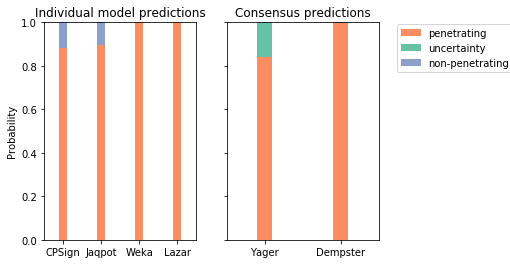

In [7]:
colorPenetrating = '#fc8d62'
colorNonpenetrating = '#8da0cb'
colorUncertainty = '#66c2a5'

def color_prediction(state):
    if state == 'P':
        return colorPenetrating
    else:
        return colorNonpenetrating
    
def color_antiprediction(state):
    if state == 'P':
        return colorNonpenetrating
    else:
        return colorPenetrating

fig, axs = plt.subplots(1, 2)

width = 0.2

# left plot - individual models
for i in range(len(models)):
    axs[0].bar(i, models_prob[models[i]], width, bottom=0, color=color_prediction(models_pred[models[i]]) )
    axs[0].bar(i, (1 - models_prob[models[i]]), width, bottom=models_prob[models[i]], color=color_antiprediction(models_pred[models[i]]))
    
axs[0].set_xticks(range(len(models)))    
axs[0].set_xticklabels(models)
axs[0].set_xlim(-0.5, len(models) - 0.5)
axs[0].set_ylabel('Probability')
axs[0].set_ylim(0, 1)
axs[0].set_title('Individual model predictions')

# right plot - consensus models
axs[1].bar(0, bel['Y']['P'], width, bottom=0, color=colorPenetrating)
axs[1].bar(0, (pls['Y']['P'] - bel['Y']['P']), width, bottom=bel['Y']['P'], color=colorUncertainty)
axs[1].bar(0, bel['Y']['N'], width, bottom=pls['Y']['P'], color=colorNonpenetrating)

p1 = axs[1].bar(1, bel['D']['P'], width, bottom=0, color=colorPenetrating)
p2 = axs[1].bar(1, (pls['D']['P'] - bel['D']['P']), width, bottom=bel['D']['P'], color=colorUncertainty)
p3 = axs[1].bar(1, bel['D']['N'], width, bottom=pls['D']['P'], color=colorNonpenetrating)

axs[1].set_xticks([0, 1])    
axs[1].set_xticklabels(['Yager', 'Dempster'])
axs[1].set_xlim(-0.5, 1.5)
axs[1].set_ylabel('')
axs[1].set_yticklabels('')
axs[1].set_ylim(0, 1)
axs[1].set_title('Consensus predictions')

fig.legend((p1[0], p2[0], p3[0]), ('penetrating', 'uncertainty', 'non-penetrating'), bbox_to_anchor=(1.2, 0.85))

fig.show()